In [100]:
import numpy as np
import scipy as sp
import scipy.linalg
import scipy.sparse.linalg
import matplotlib.pyplot as plt
import pandas as pd 
from math import sqrt
from sklearn.metrics.pairwise import rbf_kernel
%matplotlib inline

In [101]:
Z_coord = pd.read_csv('C:/Users/Anna/Documents/Skoltech/3D elevation/USGS_NED_one_meter_x44y371_AL_3County_2015_IMG_2017/USGS_NED_one_meter_x44y371_AL_3County_2015_IMG_2017.xyz',
                          header=None, engine='c', sep=' ', usecols='Z',
                          names=list('XYZ'), dtype={'Z':np.float32})

In [102]:
init_xy = pd.read_csv('C:/Users/Anna/Documents/Skoltech/3D elevation/USGS_NED_one_meter_x44y371_AL_3County_2015_IMG_2017/USGS_NED_one_meter_x44y371_AL_3County_2015_IMG_2017.xyz',
                          nrows=1, header=None, engine='c', sep=' ', usecols='XY',
                          names=list('XYZ'), dtype={'X':np.float32, 'Y':np.float32, 'Z':np.float32})

In [103]:
k = 100
g  = np.arange(sqrt(len(Z_coord)),dtype=np.int32)
xx,yy = np.meshgrid(g[::k], g[::k])
xx

array([[    0,   100,   200, ...,  9800,  9900, 10000],
       [    0,   100,   200, ...,  9800,  9900, 10000],
       [    0,   100,   200, ...,  9800,  9900, 10000],
       ..., 
       [    0,   100,   200, ...,  9800,  9900, 10000],
       [    0,   100,   200, ...,  9800,  9900, 10000],
       [    0,   100,   200, ...,  9800,  9900, 10000]])

In [104]:
xx_r = xx.ravel()
yy_r = yy.ravel()
xx_len = int(len(xx_r))
yy_len = int(len(yy_r))

xx_sqrt = int(sqrt(len(xx_r)))
yy_sqrt = int(sqrt(len(yy_r)))

In [105]:
coarse_grid = np.vstack([xx_r,yy_r]).T

In [106]:
t  = np.arange(sqrt(len(Z_coord)),dtype=np.int32)
xx_1,yy_1 = np.meshgrid(t, t)

xx_1r = xx_1.ravel()
yy_1r = yy_1.ravel()

fine_grid = np.vstack([xx_1r,yy_1r]).T

In [107]:
l = int(sqrt(len(Z_coord)))

In [108]:
z = Z_coord.iloc[np.ravel_multi_index([yy_r,xx_r], dims= (l, l))]

In [109]:
coarse_data = z.values.reshape(xx_sqrt, yy_sqrt)

In [110]:
sigma = 5

In [111]:
def krige_matvec(vec, xx_sqrt, yy_sqrt, dx=k, dy=k, sigma=3.): 
    
    tx = np.exp(-1/(sigma**2) * (dx**2) * (np.arange(xx_sqrt))**2)  
    ty = np.exp(-1/(sigma**2) * (dy**2) * (np.arange(yy_sqrt))**2) 
    upper_block = np.kron(np.expand_dims(tx, axis=1), np.expand_dims(ty, axis=0))
    horz_circ = np.concatenate((upper_block, np.flip(upper_block, axis=0)[:-1]), axis=0)
    tot_circ = np.concatenate((horz_circ, np.flip(horz_circ, axis=1)[:,:-1]), axis=1)
    
    vec_mat = np.reshape(vec, ((xx_sqrt,yy_sqrt)))
    vec_padded = np.pad(vec_mat, ((0,xx_sqrt-1),(0,yy_sqrt-1)),'constant')
    
    out = np.fft.ifft2(np.fft.fft2(tot_circ) * np.fft.fft2(vec_padded))[:xx_sqrt, :yy_sqrt]
    return np.reshape(out, (xx_sqrt*yy_sqrt,1)).squeeze()

In [112]:
Kxx_LO = scipy.sparse.linalg.LinearOperator((xx_len, yy_len), matvec=lambda v, sigma=sigma, xx_sqrt=xx_sqrt, yy_sqrt=yy_sqrt: 
                                            krige_matvec(v, xx_sqrt=xx_sqrt, yy_sqrt=yy_sqrt, sigma=sigma))

In [113]:
regularize = 1e-3 * sp.sparse.identity(xx_sqrt*yy_sqrt)
krige = sp.sparse.linalg.gmres(Kxx_LO + sp.sparse.linalg.aslinearoperator(regularize), z, maxiter=15)

In [114]:
Kxx_c = Kxx_LO.dot(krige[0]).real

Text(0.5,1,'K_xx . c')

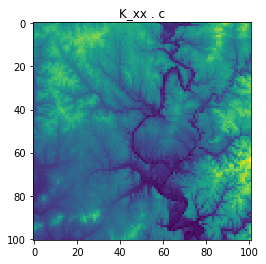

In [115]:
plt.imshow(coarse_data)
plt.title('coarse data')

plt.imshow(np.reshape(test, (xx_sqrt,yy_sqrt)))
plt.title('K_xx . c')


Text(0.5,1,'coarse data')

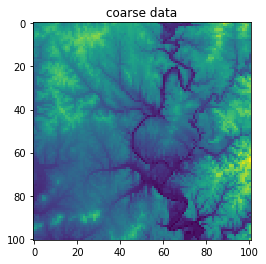

In [116]:
plt.imshow(coarse_data)
plt.title('coarse data')

In [ ]:
K_zx = rbf_kernel(fine_grid, coarse_grid, gamma=1/sigma**2)

In [ ]:
fine_data = K_zx.dot(krige[0]).real